In [2]:
import geopandas
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import xarray as xr
from netCDF4 import Dataset
from shapely.geometry import mapping

import rasterio
from rasterio.features import geometry_mask

In [3]:
hex_color_codes = [
    '#008180', '#00b44a', '#a2fd6e',
    '#ffffff', '#fefe53', '#fdd28a', '#ffa938', '#ec0013', '#760005'
]


In [4]:
def get_drought_class(value):
    if value <= -2.00:
        color_code = '#760005'
        rgb_code = 'rgb(118, 0, 5)'
        class_name = 'Exceptionally Dry'
    elif -2.00 <= value < -1.50:
        color_code = '#ec0013'
        rgb_code = 'rgb(236, 0, 19)'
        class_name = 'Extremely Dry'
    elif -1.50 <= value < -1.20:
        color_code = '#ffa938'
        rgb_code = 'rgb(255, 169, 56)'
        class_name = 'Severely Dry'
    elif -1.20 <= value < -0.70:
        color_code = '#fdd28a'
        rgb_code = 'rgb(253, 210, 138)'
        class_name = 'Moderately Dry'
    elif -0.70 <= value < -0.50:
        color_code = '#fefe53'
        rgb_code = 'rgb(254, 254, 83)'
        class_name = 'Abnormally Dry'
    elif -0.50 <= value < 0.50:
        color_code = '#ffffff'
        rgb_code = 'rgb(255, 255, 255)'
        class_name = 'Near Normal'
    elif 0.50 <= value < 0.70:
        color_code = '#a2fd6e'
        rgb_code = 'rgb(162, 253, 110)'
        class_name = 'Abnormally Moist'
    elif 0.70 <= value < 1.20:
        color_code = '#00b44a'
        rgb_code = 'rgb(0, 180, 74)'
        class_name = 'Moderately Moist'
    elif 1.20 <= value < 1.50:
        color_code = '#008180'
        rgb_code = 'rgb(0, 129, 128)'
        class_name = 'Very Moist'
    elif 1.50 <= value < 2.00:
        color_code = '#2a23eb'
        rgb_code = 'rgb(42, 35, 235)'
        class_name = 'Extremely Moist'
    elif value >= 2.00:
        color_code = '#a21fec'
        rgb_code = 'rgb(162, 31, 236)'
        class_name = 'Exceptionally Moist'
    else:
        color_code = None
        rgb_code = None
        class_name = None

    return color_code, rgb_code, class_name

## Visualizing Standardized Precipitation Index

In [5]:
ds = xr.open_mfdataset('../data/spi_output/mar_cli_chirps_spi_gamma_6_month.nc', parallel=True)
df = ds.to_dataframe().reset_index()
gdf = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df["lon"],df["lat"]))

In [6]:
gdf['class'] = gdf['spi_gamma_6_month'].apply(lambda x: get_drought_class(x)[2])

In [7]:
morocco_adm0 = geopandas.read_file('../data/shapefiles/mar_adm0.shp')
morocco_adm1 = geopandas.read_file('../data/shapefiles/mar_adm1.shp')
morocco_adm2 = geopandas.read_file('../data/shapefiles/mar_adm2.shp')

Assumptions 
* Remove all areas where spi is blank


In [8]:
def count_pixels_in_polygon(polygon, transform, shape):
    mask = geometry_mask([polygon], out_shape=shape, transform=transform, invert=False)
    return mask.sum()

# Loop through the GeoDataFrame rows and count pixels for each polygon

# adm 0 = 0.061
# adm1 = 

def get_pixel_count_for_polygon(gdf, resolution):
    pixel_counts = []
    for index, row in gdf.iterrows():
        polygon = row.geometry
        minx, miny, maxx, maxy = polygon.bounds
        x_res = y_res = resolution  # Adjust this based on your data
        shape = (int((maxy - miny) // y_res), int((maxx - minx) // x_res))
        transform = rasterio.transform.from_origin(minx, maxy, x_res, y_res)
        pixel_count = count_pixels_in_polygon(polygon, transform, shape)
        pixel_counts.append(pixel_count)

    # Add pixel counts as a new column in the GeoDataFrame
    gdf['pixel_count'] = pixel_counts

    return gdf


In [9]:
morocco_adm0 = get_pixel_count_for_polygon(morocco_adm0, 0.061)

In [158]:
# fivide by the sum total of all the pixels in morocco
gdf_adm0 = gdf.groupby(['class', 'time']).count()
gdf_adm0['percentage_area'] = 100*gdf_adm0['geometry']/16239

In [159]:
p = gdf_adm0.reset_index().set_index('time')[['class', 'percentage_area']].pivot_table(columns ='class', values='percentage_area', index = 'time')
p = p [[
    'Very Moist', 'Moderately Moist',
    'Abnormally Moist', 'Near Normal', 'Abnormally Dry', 'Moderately Dry',
    'Severely Dry', 'Extremely Dry', 'Exceptionally Dry'
]]

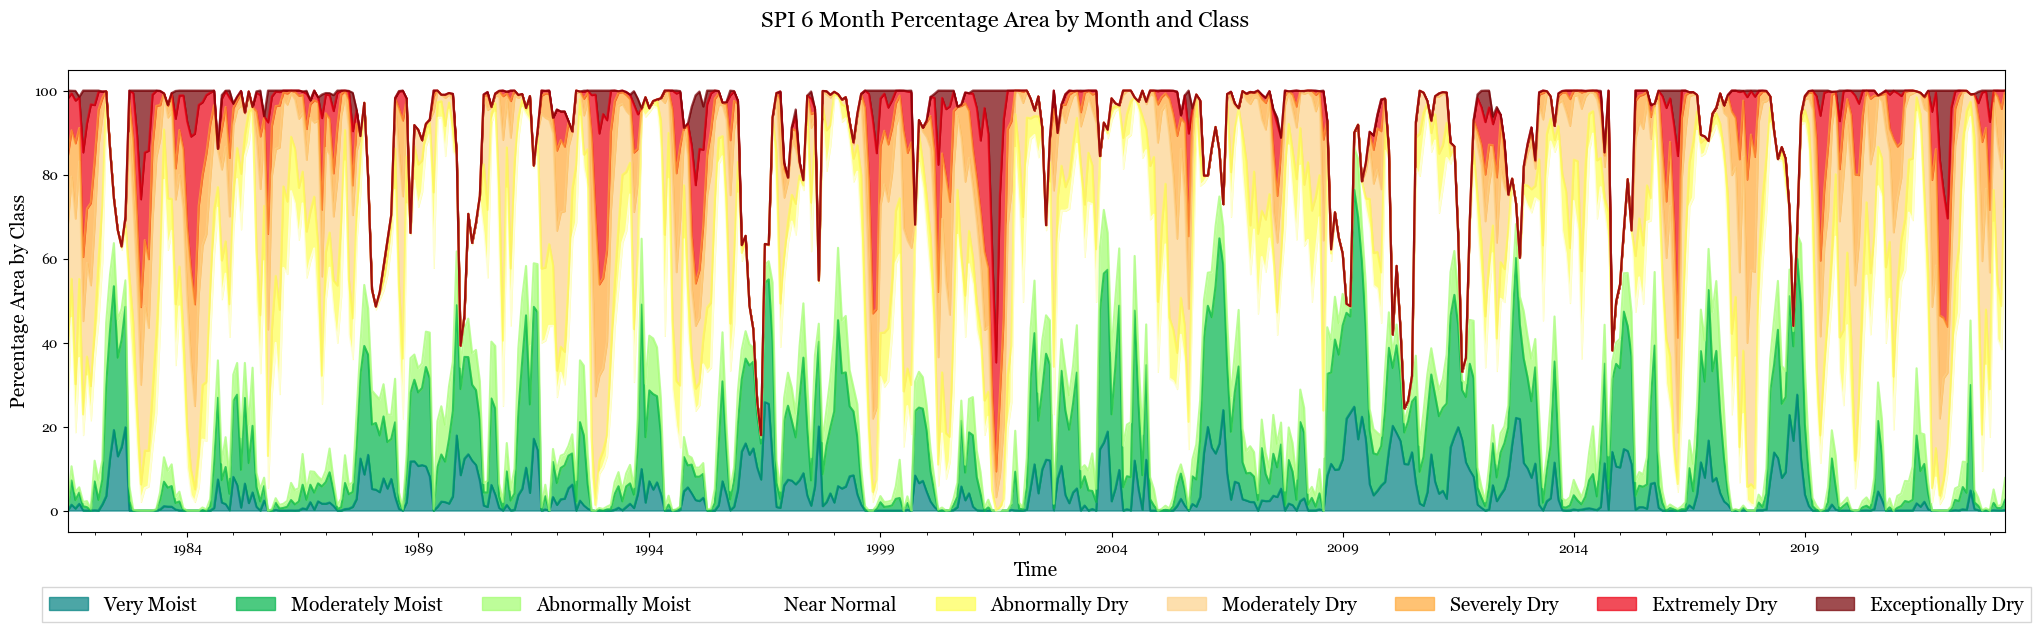

In [177]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(25,6))


p.plot(kind='area', stacked=True, alpha = 0.7, color = hex_color_codes, ax=ax)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Percentage Area by Class', fontsize = 14)
ax.legend(title='Classes')

fig.suptitle('SPI 6 Month Percentage Area by Month and Class', fontsize=16)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=False, shadow=False, ncol=9, fontsize=14)

### Observations 
* The empty spaces are because of null values of SPI
* 2022, 2016, 2011-2002 were years of drought within Morocco

In [13]:
gdf_adm1 = morocco_adm1.sjoin(gdf)

c:\Users\sahit\anaconda3\envs\heatwaves\lib\site-packages\geopandas\geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [14]:
morocco_adm1 = get_pixel_count_for_polygon(morocco_adm1, 0.0436)

In [15]:
gdf_adm1 = gdf_adm1.groupby(['time', 'adm1_name', 'class']).count()

In [16]:
gdf_adm1 = gdf_adm1[['geometry']].reset_index()

In [17]:
gdf_adm1 = morocco_adm1[['adm1_name', 'pixel_count']].merge(gdf_adm1)
gdf_adm1.rename(columns = {'pixel_count':'adm_area', 'geometry':'class_area'}, inplace=True)
gdf_adm1['percentage_area'] = 100*gdf_adm1['class_area']/gdf_adm1['adm_area']

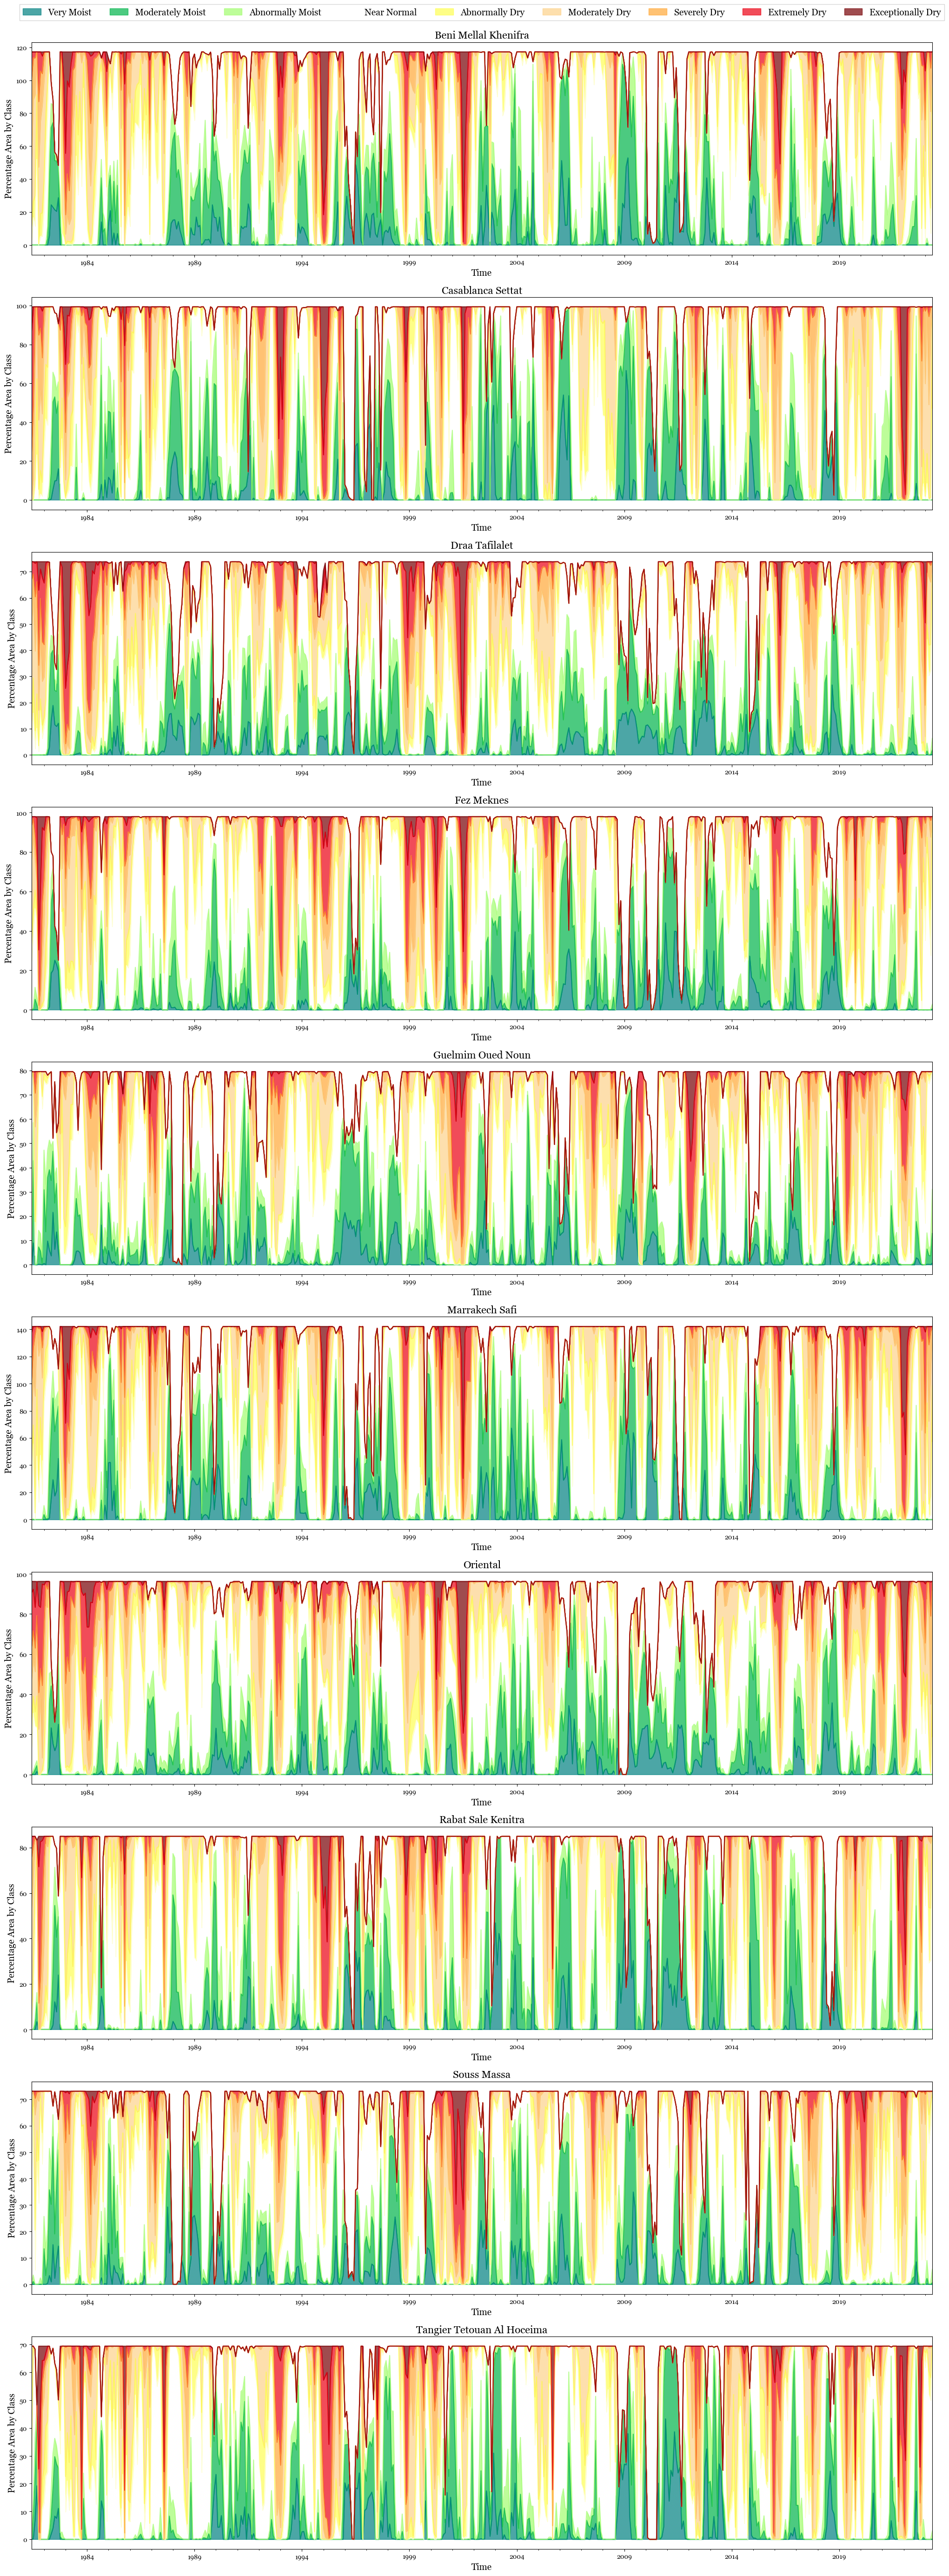

In [178]:
from matplotlib import rcParams

p = gdf_adm1[['adm1_name', 'time', 'percentage_area', 'class']]

rcParams['font.family'] = 'Georgia'
rcParams['font.sans-serif'] = ['Georgia']

fig, ax = plt.subplots(len(gdf_adm1['adm1_name'].unique()), 1, figsize=(25,70))

for i, adm in enumerate(gdf_adm1['adm1_name'].unique()):
    p1 = p[p['adm1_name']==adm]
    p1 = p1.reset_index().set_index('time')[['class', 'percentage_area']].pivot_table(columns ='class', values='percentage_area', index = 'time')
    p1 = p1 [[
    'Very Moist', 'Moderately Moist',
    'Abnormally Moist', 'Near Normal', 'Abnormally Dry', 'Moderately Dry',
    'Severely Dry', 'Extremely Dry', 'Exceptionally Dry']]

    p1.plot(kind='area', stacked=True, alpha = 0.7, color = hex_color_codes, ax=ax[i], legend = False)
    ax[i].set_xlabel('Time', fontsize=14)
    ax[i].set_ylabel('Percentage Area by Class', fontsize=14)
    #ax[i].legend(title='Categories')
    ax[i].set_title(adm, fontsize=16)
 
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 12), fancybox=False, shadow=False, ncol=9, fontsize=14)

## Admin 1 regions in Dry Classes 

Dry Classes constitue of 'Abnormally Dry', 'Extremely Dry', 'Severely Dry', 'Exceptionally Dry'

In [23]:
gdf_adm1['class'].unique()

array(['Abnormally Dry', 'Extremely Dry', 'Moderately Dry', 'Near Normal',
       'Severely Dry', 'Exceptionally Dry', 'Abnormally Moist',
       'Moderately Moist', 'Very Moist', 'Extremely Moist',
       'Exceptionally Moist'], dtype=object)

In [25]:
extreme_dry_class = ['Abnormally Dry', 'Extremely Dry', 'Severely Dry', 'Exceptionally Dry']
moist_class = ['Abnormally Moist',
       'Moderately Moist', 'Very Moist', 'Extremely Moist',
       'Exceptionally Moist']

def get_class_type(x):
    if x in extreme_dry_class:
        return 'Dry Classes'
    elif x in moist_class:
        return 'Moist Classes'
    else:
        return 'Normal'

In [26]:
gdf_adm1['class_type'] = gdf_adm1['class'].apply(lambda x: get_class_type(x))

In [118]:
cmap = ['Reds', 'Greens', 'Greys']

Text(0.5, 0.98, 'Maximum Percentage Area in SPI 6 month Drought Classes in a year by Adm1 Regions')

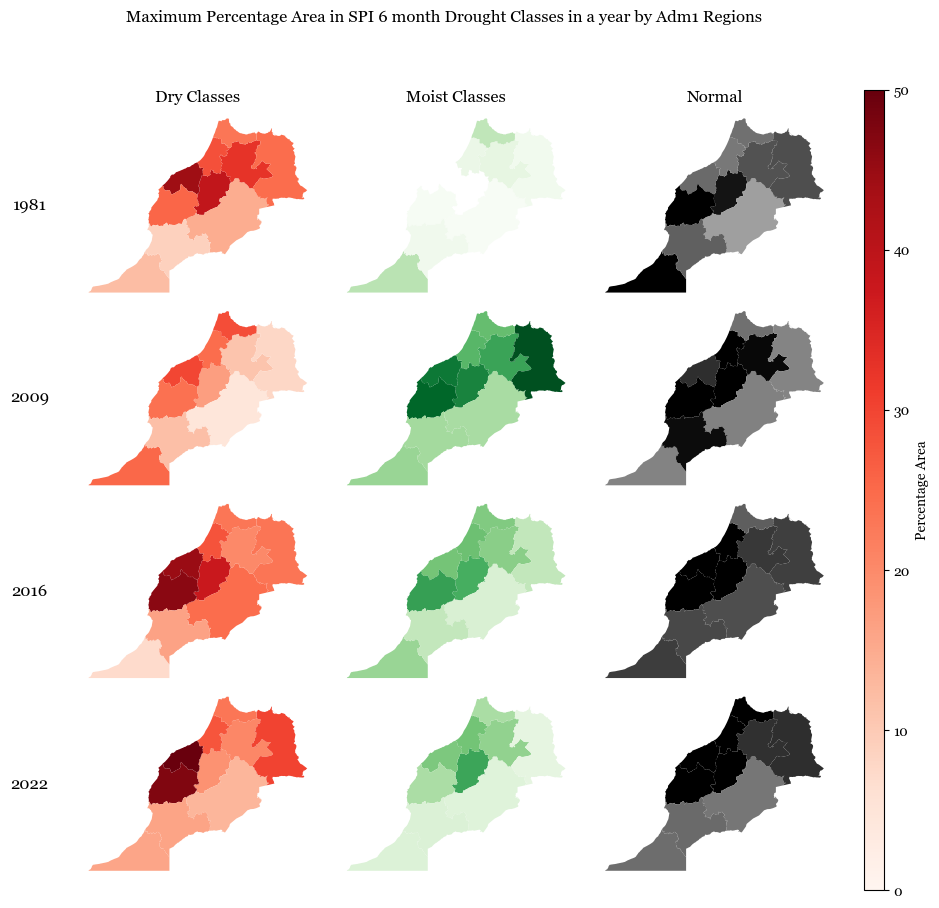

In [191]:
p = gdf_adm1.groupby(['adm1_name', 'class_type', 'time']).sum().reset_index()
p['percentage_area'] = 100*p['class_area']/p['adm_area']
p = p.groupby(['adm1_name', 'class_type', pd.Grouper(key='time', freq='Y')]).max().reset_index()
p = morocco_adm1[['adm1_name', 'geometry']].merge(p)
p = geopandas.GeoDataFrame(p, geometry='geometry')

fig, ax = plt.subplots(4,3, figsize=(10,10), sharex=True, sharey=True)

plots = []
for i, year in enumerate([1981, 2009, 2016, 2022]):
    p1 = p[p['time'].dt.year==year]
    ax[i][0].text(-0.2, 0.5, year, va='center', ha='center', fontsize=12,  transform=ax[i][0].transAxes,)
    for idx, class_type in enumerate(['Dry Classes', 'Moist Classes', 'Normal']):
        p2 = p1[p1['class_type']==class_type]
        plot = p2.plot(column='percentage_area',ax=ax[i][idx], cmap = cmap[idx], vmin=0, vmax=50)
        ax[i][idx].axis('off')
        plots.append(plot)
        ax[0][idx].set_title(class_type)
        #ax[idx][0].set_title(year)
    
    

cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position as needed
sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=0, vmax=50))
sm.set_array([])  # Fake empty array for the colorbar
cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
cbar.set_label('Percentage Area')

plt.subplots_adjust(wspace=0.00005, hspace=0.005)

fig.suptitle('Maximum Percentage Area in SPI 6 month Drought Classes in a year by Adm1 Regions')


### Observations

The figure shows the maximum percentage area in each year that can be classified as dry, moist or normal based on the SPI classes i.e., it talks about the **worst months of drought or rainfall**. 

* 2009 was one of the years which was reltively moist 
* 2016 and 2022 were years with high dry conditions after 1981, as also validated by news outlets 
    * [2016 drought](https://thearabweekly.com/morocco-braces-drought-fallout)
    * [2022 drought](https://www.reuters.com/world/africa/morocco-spend-1-bln-mitigate-drought-impact-palace-2022-02-16/)


Text(0.5, 0.98, 'Max Percentage Area in Moist Classes in a year by Adm1 Regions')

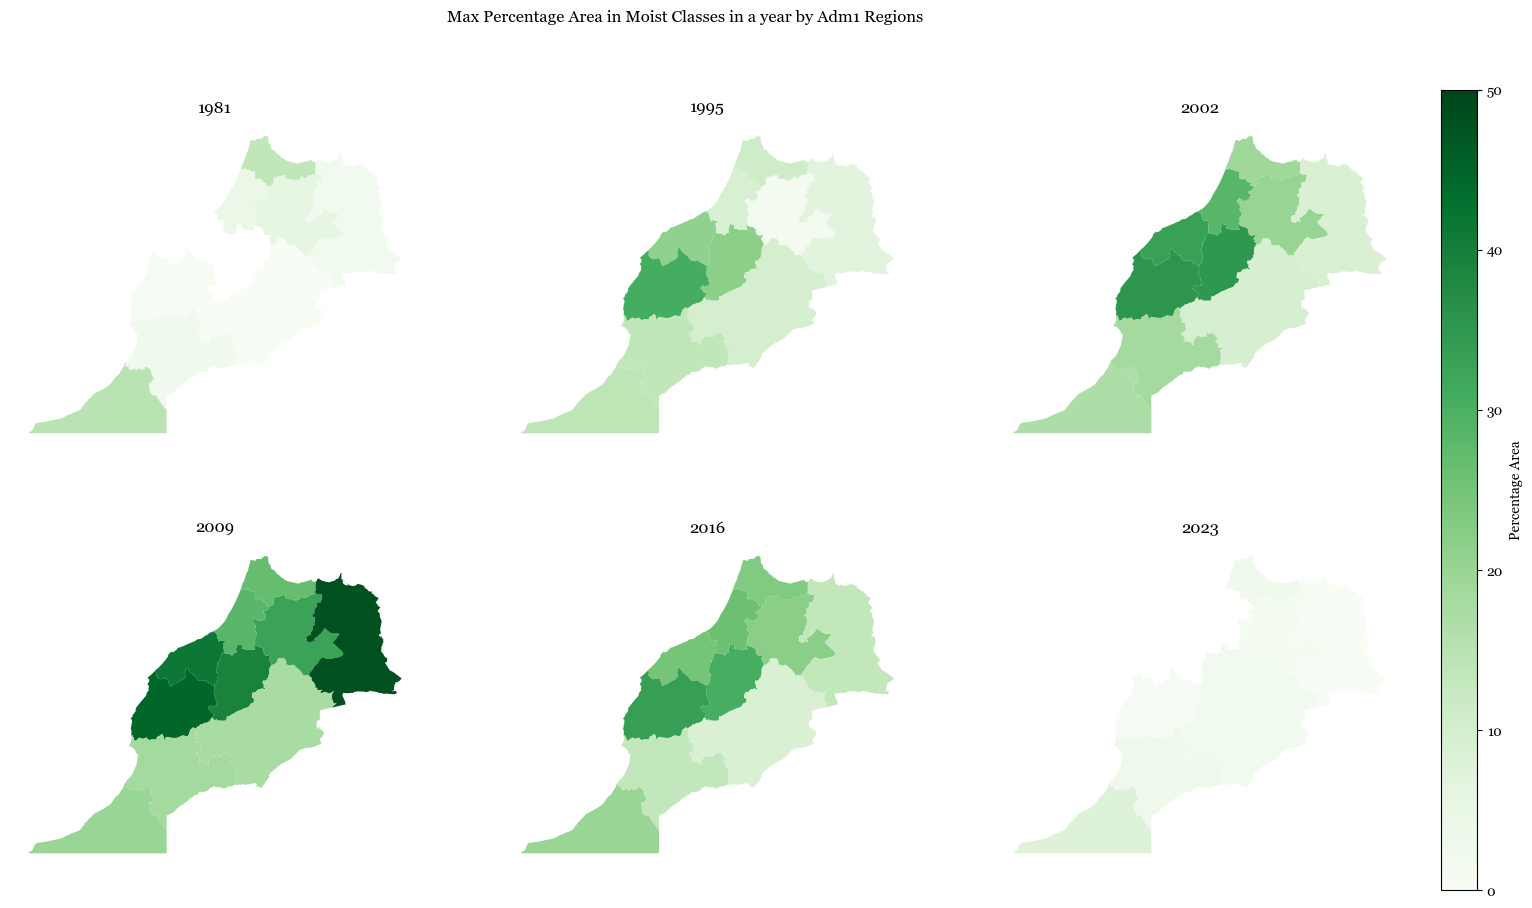

In [112]:
# p = gdf_adm1.groupby(['adm1_name', 'class_type', 'time']).sum().reset_index()
# p['percentage_area'] = 100*p['class_area']/p['adm_area']
# p = p.groupby(['adm1_name', 'class_type', pd.Grouper(key='time', freq='Y')]).max().reset_index()
# p = morocco_adm1[['adm1_name', 'geometry']].merge(p)
# p = geopandas.GeoDataFrame(p, geometry='geometry')

# fig, axs = plt.subplots(2,3, figsize=(18,10), sharex=True, sharey=True)
# ax = axs.flatten()
# plots = []
# for i, year in enumerate([1981, 1995, 2002,2009, 2016, 2023]):
#     p1 = p[p['time'].dt.year==year]
#     p1 = p1[p1['class_type']=='Moist Classes']
#     plot = p1.plot(column='percentage_area',ax=ax[i], cmap = 'Greens', vmin=0, vmax=50)
#     plots.append(plot)
#     ax[i].set_title(year)
#     ax[i].axis('off')

# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust the position as needed
# sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=0, vmax=50))
# sm.set_array([])  # Fake empty array for the colorbar
# cbar = plt.colorbar(sm, cax=cax, orientation='vertical')
# cbar.set_label('Percentage Area')

# fig.suptitle('Max Percentage Area in Moist Classes in a year by Adm1 Regions')


In [85]:
gdf_adm1.to_csv('../data/spi_class_adm1.csv')